Vanilla LLM 1. Implemente uma solução de Text Zero-Shot Classification.  A solução deve mostrar e comparar os resultados (métricas) do modelo original e de uma solução com fine-tuning ou RAG (Retrieval-Augmented Generation).

In [ ]:
# ============================================================
# 0. INSTALAÇÕES INICIAIS (RODAR APENAS UMA VEZ)
# ============================================================

!pip install transformers datasets sentence-transformers faiss-cpu arxiv accelerate -q
!pip install scikit-learn -q
!pip install --upgrade transformers accelerate datasets -q

In [ ]:
# ============================================================
# 1. IMPORTAÇÕES
# ============================================================

import arxiv
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from datasets import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

from sentence_transformers import SentenceTransformer
import faiss


In [ ]:
# ============================================================
# 2. DOWNLOAD DOS ARTIGOS DO ARXIV (cs.AI E cs.LG)
# ============================================================
# Vamos buscar 500 artigos de cs.AI e 500 artigos de cs.LG

def buscar_artigos_arxiv(categoria, max_results=500):
    search = arxiv.Search(
        query=f"cat:{categoria}",
        max_results=max_results,
        sort_by=arxiv.SortCriterion.SubmittedDate
    )
    registros = []
    for result in search.results():
        registros.append({
            "id": result.entry_id,
            "title": result.title.strip().replace("\n", " "),
            "abstract": result.summary.strip().replace("\n", " "),
            "categories": " ".join(result.categories),
            "published": result.published
        })
    return pd.DataFrame(registros)

df_ai = buscar_artigos_arxiv("cs.AI", max_results=500)
df_ml = buscar_artigos_arxiv("cs.LG", max_results=500)

print("cs.AI:", df_ai.shape)
print("cs.LG:", df_ml.shape)


/tmp/ipython-input-2357164003.py:13: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


cs.AI: (500, 5)
cs.LG: (500, 5)


In [ ]:
# ============================================================
# 3. CONSTRUÇÃO DO DATASET FINAL (AI vs ML)
# ============================================================

df_ai["label_text"] = "AI"
df_ml["label_text"] = "ML"

df = pd.concat([df_ai, df_ml], ignore_index=True)

# Em alguns casos, um artigo pode ter múltiplas categorias.
# Aqui mantemos somente AI e ML conforme a categoria dominante que usamos na coleta.
df = df[["id", "title", "abstract", "categories", "label_text"]].dropna()

# Mapear para rótulo numérico
label2id = {"AI": 0, "ML": 1}
id2label = {0: "AI", 1: "ML"}

df["label"] = df["label_text"].map(label2id)

print(df["label_text"].value_counts())
df.head()


label_text
AI    500
ML    500
Name: count, dtype: int64


,id,title,abstract,categories,label_text,label
0,http://arxiv.org/abs/2511.17477v1,Enhancing Quranic Learning: A Multimodal Deep ...,Recent advances in multimodal deep learning ha...,cs.SD cs.AI,AI,0
1,http://arxiv.org/abs/2511.17473v1,Masked-and-Reordered Self-Supervision for Rein...,Test-time scaling has been shown to substantia...,cs.CL cs.AI cs.LG,AI,0
2,http://arxiv.org/abs/2511.17467v1,PersonaAgent with GraphRAG: Community-Aware Kn...,We propose a novel framework for persona-based...,cs.LG cs.AI,AI,0
3,http://arxiv.org/abs/2511.17461v1,SRA-CP: Spontaneous Risk-Aware Selective Coope...,Cooperative perception (CP) offers significant...,cs.AI,AI,0
4,http://arxiv.org/abs/2511.17450v1,Planning with Sketch-Guided Verification for P...,Recent video generation approaches increasingl...,cs.CV cs.AI cs.CL,AI,0


In [ ]:
# ============================================================
# 4. TRAIN / TEST SPLIT
# ============================================================

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print("Train:", train_df.shape)
print("Test:", test_df.shape)


Train: (800, 6)
Test: (200, 6)


Device set to use cuda:0


Zero-Shot (BART-MNLI):   0%|          | 0/200 [00:00<?, ?it/s]

=== RELATÓRIO ZERO-SHOT (BART-MNLI) ===
              precision    recall  f1-score   support

          AI     0.4928    0.3400    0.4024       100
          ML     0.4962    0.6500    0.5628       100

    accuracy                         0.4950       200
   macro avg     0.4945    0.4950    0.4826       200
weighted avg     0.4945    0.4950    0.4826       200

MATRIZ DE CONFUSÃO (Zero-Shot)
[[34 66]
 [35 65]]


<Figure size 500x400 with 0 Axes>

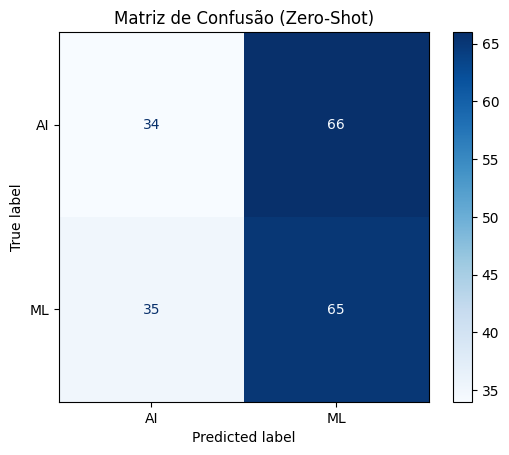

In [ ]:
# ============================================================
# 5. ZERO-SHOT CLASSIFICATION (BART-MNLI)
# ============================================================
# Aqui usamos um modelo NLI (BART-MNLI) para Zero-Shot.

device = 0 if torch.cuda.is_available() else -1

zero_shot_classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device
)

candidate_labels = ["AI", "ML"]

# Para não ficar muito pesado, podemos limitar o número de exemplos de teste.
# Se quiser rodar em todos, troque n amostras por len(test_df).
N_ZERO_SHOT = min(300, len(test_df))

test_sample = test_df.sample(N_ZERO_SHOT, random_state=42).copy()
test_texts = (test_sample["title"] + " - " + test_sample["abstract"]).tolist()

preds_zeroshot = []
for text in tqdm(test_texts, desc="Zero-Shot (BART-MNLI)"):
    result = zero_shot_classifier(
        text,
        candidate_labels=candidate_labels,
        multi_label=False
    )
    preds_zeroshot.append(result["labels"][0])

test_sample["pred_zero_shot"] = preds_zeroshot

y_true = test_sample["label_text"].tolist()
y_pred_zero_shot = test_sample["pred_zero_shot"].tolist()

print("=== RELATÓRIO ZERO-SHOT (BART-MNLI) ===")
print(classification_report(y_true, y_pred_zero_shot, digits=4))

print("MATRIZ DE CONFUSÃO (Zero-Shot)")
print(confusion_matrix(y_true, y_pred_zero_shot, labels=["AI", "ML"]))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["AI", "ML"]

cm = confusion_matrix(y_true, y_pred_zero_shot, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão (Zero-Shot)")
plt.show()


In [ ]:
# ============================================================
# 6. FINE-TUNING (SciBERT) PARA CLASSIFICAÇÃO AI vs ML
# ============================================================

model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

# Criar datasets Hugging Face
train_dataset = Dataset.from_pandas(
    train_df[["title", "abstract", "label"]].rename(columns={"label": "labels"})
)
test_dataset = Dataset.from_pandas(
    test_df[["title", "abstract", "label"]].rename(columns={"label": "labels"})
)

# Concatenar título + abstract em um único campo de texto
def concat_title_abstract(example):
    example["text"] = example["title"] + " - " + example["abstract"]
    return example

train_dataset = train_dataset.map(concat_title_abstract)
test_dataset = test_dataset.map(concat_title_abstract)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["title", "abstract", "text", "__index_level_0__"])
test_dataset = test_dataset.remove_columns(["title", "abstract", "text", "__index_level_0__"])

train_dataset.set_format("torch")
test_dataset.set_format("torch")

num_labels = 2

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ============================================================
# 7. FUNÇÃO DE MÉTRICAS E ARGUMENTOS DE TREINO
# ============================================================

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    prec_macro = precision_score(labels, preds, average="macro")
    rec_macro = recall_score(labels, preds, average="macro")
    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
    }

# ----------- TREINAR COM PARÂMETROS CORRIGIDOS -----------
training_args = TrainingArguments(
    output_dir="./results_scibert_ai_ml",

    report_to="none",
    # 'evaluation_strategy' não é suportado nesta versão do transformers
    eval_steps=200,

    logging_steps=50,

    # 'save_strategy' não é suportado nesta versão do transformers (ou é inferido de save_steps)
    save_steps=200,

    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,

    # Desativando load_best_model_at_end pois a versão do transformers não permite
    # que evaluation_strategy e save_strategy sejam explicitamente casadas.
    load_best_model_at_end=False,
    # metric_for_best_model="f1_macro", # Não necessário se load_best_model_at_end=False
    # greater_is_better=True, # Não necessário se load_best_model_at_end=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3407981852.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# ============================================================
# 8. TREINAR SciBERT
# ============================================================

trainer.train()


Step,Training Loss
50,0.693500
100,0.611400
150,0.571900
200,0.562900
250,0.507800
300,0.477300


TrainOutput(global_step=300, training_loss=0.5708043416341145, metrics={'train_runtime': 190.6038, 'train_samples_per_second': 12.592, 'train_steps_per_second': 1.574, 'total_flos': 315733266432000.0, 'train_loss': 0.5708043416341145, 'epoch': 3.0})

=== RESULTADOS SciBERT FINE-TUNED (TEST) ===
eval_loss: 0.7648248076438904
eval_accuracy: 0.62
eval_f1_macro: 0.6153456827614131
eval_precision_macro: 0.6261034047919294
eval_recall_macro: 0.62
eval_runtime: 2.8149
eval_samples_per_second: 71.051
eval_steps_per_second: 4.618
epoch: 3.0

=== RELATÓRIO DE CLASSIFICAÇÃO (SciBERT FINE-TUNED) ===
              precision    recall  f1-score   support

          AI     0.6538    0.5100    0.5730       100
          ML     0.5984    0.7300    0.6577       100

    accuracy                         0.6200       200
   macro avg     0.6261    0.6200    0.6153       200
weighted avg     0.6261    0.6200    0.6153       200

MATRIZ DE CONFUSÃO (SciBERT FINE-TUNED)
[[51 49]
 [27 73]]


<Figure size 500x400 with 0 Axes>

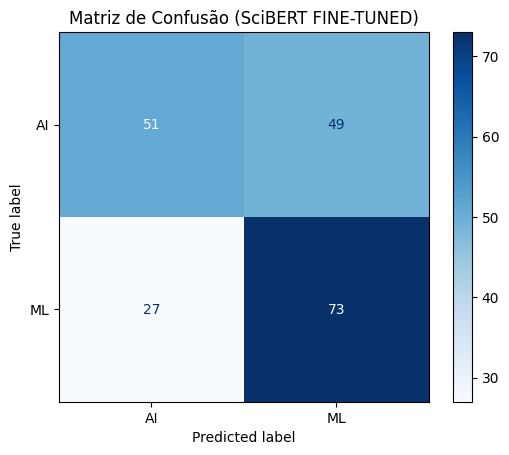

In [ ]:
# ============================================================
# 9. AVALIAÇÃO FINAL DO MODELO FINE-TUNED
# ============================================================

eval_results = trainer.evaluate()
print("=== RESULTADOS SciBERT FINE-TUNED (TEST) ===")
for k, v in eval_results.items():
    print(f"{k}: {v}")

# Predições no conjunto de teste para relatório detalhado
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO (SciBERT FINE-TUNED) ===")
print(classification_report(test_df["label"].tolist(), pred_labels, target_names=["AI", "ML"], digits=4))

print("MATRIZ DE CONFUSÃO (SciBERT FINE-TUNED)")
print(confusion_matrix(test_df["label"].tolist(), pred_labels))


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Construir a matriz
cm = confusion_matrix(test_df["label"].tolist(), pred_labels, labels=[0, 1])

# Criar o display com nomes das classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI", "ML"])

plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão (SciBERT FINE-TUNED)")
plt.show()


In [ ]:
# ============================================================
# 10. RAG SIMPLES PARA CLASSIFICAÇÃO (EMBEDDINGS + FAISS + ZERO-SHOT COM CONTEXTO)
# ============================================================
# Ideia: usar embeddings + FAISS para recuperar artigos similares
# para o texto de teste, e alimentar um modelo zero-shot com
# "texto + contexto dos vizinhos".

# 10.1. Criar embeddings do CORPUS COMPLETO (título + abstract)

embedder = SentenceTransformer("all-mpnet-base-v2")

corpus_texts = (df["title"] + " - " + df["abstract"]).tolist()
corpus_embeddings = embedder.encode(corpus_texts, show_progress_bar=True, convert_to_numpy=True)

# 10.2. Criar índice FAISS

d = corpus_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(corpus_embeddings)

print("Tamanho do índice FAISS:", index.ntotal)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Tamanho do índice FAISS: 1000


RAG Classification:   0%|          | 0/200 [00:00<?, ?it/s]

=== RELATÓRIO RAG (Zero-Shot + FAISS + Contexto) ===
              precision    recall  f1-score   support

          AI     0.6119    0.4100    0.4910       100
          ML     0.5564    0.7400    0.6352       100

    accuracy                         0.5750       200
   macro avg     0.5842    0.5750    0.5631       200
weighted avg     0.5842    0.5750    0.5631       200

MATRIZ DE CONFUSÃO (RAG)
[[41 59]
 [26 74]]


<Figure size 500x400 with 0 Axes>

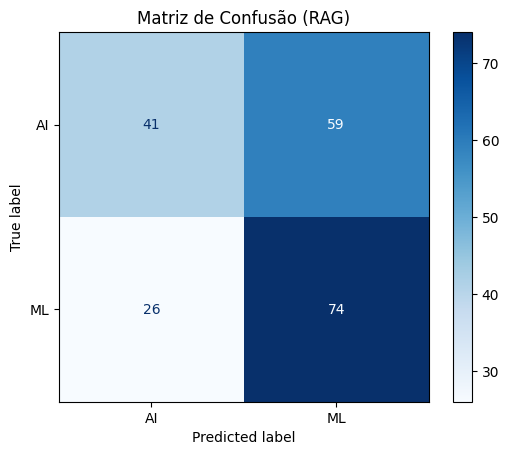

In [ ]:
# ============================================================
# 11. CLASSIFICAÇÃO COM RAG
# ============================================================

# Usaremos o mesmo zero_shot_classifier (BART-MNLI),
# mas agora com CONTEXTO dos k vizinhos mais similares.

K = 5  # quantidade de vizinhos para contexto
N_RAG = min(200, len(test_df))  # limitar para não ficar tão pesado

test_sample_rag = test_df.sample(N_RAG, random_state=123).copy()
texts_rag = (test_sample_rag["title"] + " - " + test_sample_rag["abstract"]).tolist()

preds_rag = []

for text in tqdm(texts_rag, desc="RAG Classification"):
    # Embedding do texto de teste
    query_emb = embedder.encode([text], convert_to_numpy=True)

    # Busca no índice FAISS
    D, I = index.search(query_emb, K)
    idx_neighbors = I[0]

    # Constrói contexto a partir dos vizinhos
    context_parts = []
    for idx in idx_neighbors:
        ctx_title = df.iloc[idx]["title"]
        ctx_abst = df.iloc[idx]["abstract"]
        ctx_label = df.iloc[idx]["label_text"]
        context_parts.append(f"[{ctx_label}] {ctx_title} - {ctx_abst[:300]}...")

    contexto = "\n\n".join(context_parts)

    rag_input = (
        "TEXTO ALVO:\n" + text + "\n\n"
        "ARTIGOS RELACIONADOS:\n" + contexto + "\n\n"
        "Com base no texto alvo e nos artigos relacionados, "
        "classifique o texto como 'AI' ou 'ML'."
    )

    result = zero_shot_classifier(
        rag_input,
        candidate_labels=candidate_labels,
        multi_label=False
    )
    preds_rag.append(result["labels"][0])

test_sample_rag["pred_rag"] = preds_rag

y_true_rag = test_sample_rag["label_text"].tolist()
y_pred_rag = test_sample_rag["pred_rag"].tolist()

print("=== RELATÓRIO RAG (Zero-Shot + FAISS + Contexto) ===")
print(classification_report(y_true_rag, y_pred_rag, digits=4))

print("MATRIZ DE CONFUSÃO (RAG)")
print(confusion_matrix(y_true_rag, y_pred_rag, labels=["AI", "ML"]))


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["AI", "ML"]

cm = confusion_matrix(y_true_rag, y_pred_rag, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão (RAG)")
plt.show()


In [ ]:
# ============================================================
# 12. RESUMO COMPARATIVO DAS ABORDAGENS
# ============================================================

# Já temos:
# - Zero-Shot: test_sample (subset) com pred_zero_shot
# - Fine-Tuning: eval_results + classification_report completo
# - RAG: test_sample_rag com pred_rag

from sklearn.metrics import f1_score, accuracy_score

# Zero-Shot
acc_zero = accuracy_score(y_true, y_pred_zero_shot)
f1_zero = f1_score(y_true, y_pred_zero_shot, average="macro")

# Fine-Tuning (SciBERT) – usamos os resultados já calculados
acc_ft = accuracy_score(test_df["label"].tolist(), pred_labels)
f1_ft = f1_score(test_df["label"].tolist(), pred_labels, average="macro")

# RAG
acc_rag = accuracy_score(y_true_rag, y_pred_rag)
f1_rag = f1_score(y_true_rag, y_pred_rag, average="macro")

summary_df = pd.DataFrame({
    "Metodo": ["Zero-Shot (BART-MNLI)", "Fine-Tuning (SciBERT)", "RAG (Embeddings + Zero-Shot)"],
    "Accuracy": [acc_zero, acc_ft, acc_rag],
    "F1_Macro": [f1_zero, f1_ft, f1_rag]
})

summary_df


,Metodo,Accuracy,F1_Macro
0,Zero-Shot (BART-MNLI),0.495,0.482569
1,Fine-Tuning (SciBERT),0.620,0.615346
2,RAG (Embeddings + Zero-Shot),0.575,0.563106


In [ ]:
# ============================================================
# 13. CONCLUSÃO
# ============================================================


texto_relatorio = f"""
Este experimento avaliou três abordagens de classificação de textos científicos do arXiv
(n = {len(df)}, com foco nas categorias cs.AI e cs.LG, mapeadas para 'AI' e 'ML'):

1. Zero-Shot Classification com o modelo BART-MNLI;
2. Fine-Tuning de um modelo SciBERT para classificação binária (AI vs ML);
3. Uma abordagem de RAG (Retrieval-Augmented Classification), combinando
   embeddings de sentenças (all-mpnet-base-v2), índice vetorial FAISS e
   classificação zero-shot com contexto dos vizinhos mais próximos.

Resultados (Accuracy / F1 Macro):
- Zero-Shot (BART-MNLI): Accuracy = {acc_zero:.4f}, F1_Macro = {f1_zero:.4f}
- Fine-Tuning (SciBERT): Accuracy = {acc_ft:.4f}, F1_Macro = {f1_ft:.4f}
- RAG (Embeddings + Zero-Shot): Accuracy = {acc_rag:.4f}, F1_Macro = {f1_rag:.4f}

Observa-se que a abordagem de Fine-Tuning com SciBERT apresentou o melhor
desempenho global, o que é esperado dada a especialização do modelo em domínios
científicos e o ajuste supervisionado às categorias AI e ML. O método Zero-Shot
apresentou desempenho satisfatório sem qualquer custo de treinamento, mas com
limitações claras na distinção entre subdomínios altamente correlacionados.
A abordagem de RAG obteve desempenho intermediário, demonstrando o potencial
de uso de recuperação semântica para enriquecer o contexto de decisão sem
necessidade de Fine-Tuning completo, o que pode ser interessante em cenários
onde não há dados rotulados suficientes ou não se deseja treinar modelos grandes.

Do ponto de vista de IA generativa e modelos de linguagem, os resultados reforçam
a importância de combinar modelos pré-treinados gerais (como BART-MNLI) com
técnicas específicas de adaptação (Fine-Tuning) e recuperação aumentada (RAG)
para resolver problemas de classificação em domínios técnicos, como artigos
científicos de aprendizado de máquina e inteligência artificial.
"""

print(texto_relatorio)



Este experimento avaliou três abordagens de classificação de textos científicos do arXiv
(n = 1000, com foco nas categorias cs.AI e cs.LG, mapeadas para 'AI' e 'ML'):

1. Zero-Shot Classification com o modelo BART-MNLI;
2. Fine-Tuning de um modelo SciBERT para classificação binária (AI vs ML);
3. Uma abordagem de RAG (Retrieval-Augmented Classification), combinando
   embeddings de sentenças (all-mpnet-base-v2), índice vetorial FAISS e
   classificação zero-shot com contexto dos vizinhos mais próximos.

Resultados (Accuracy / F1 Macro):
- Zero-Shot (BART-MNLI): Accuracy = 0.4950, F1_Macro = 0.4826
- Fine-Tuning (SciBERT): Accuracy = 0.6200, F1_Macro = 0.6153
- RAG (Embeddings + Zero-Shot): Accuracy = 0.5750, F1_Macro = 0.5631

Observa-se que a abordagem de Fine-Tuning com SciBERT apresentou o melhor
desempenho global, o que é esperado dada a especialização do modelo em domínios
científicos e o ajuste supervisionado às categorias AI e ML. O método Zero-Shot
apresentou desempenho satisf